In [10]:
import pandas as pd
from datetime import timedelta, datetime,date
from tqdm import tqdm
from itertools import product
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append('../src')
from data.data_split import split_data_by_year
from features.contigency_table import create_contigency_table
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

In [3]:
path_data_dir = '../data/'
list_assets = ["PETR3.SA","PRIO3.SA", "VALE3.SA", "GGBR3.SA", "ABCB4.SA", "ITUB3.SA", "FLRY3.SA", "RADL3.SA"]
list_prev_meta = [i for i in range(1,5)]

In [4]:
df_results = pd.DataFrame({})

for n_prev_meta, asset in tqdm(product(list_prev_meta, list_assets), total = len(list_prev_meta)*len(list_assets)):    
    
    data = pd.read_csv(path_data_dir + f"processed/price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv")


    data['year'] = pd.to_datetime(data.Date).dt.year

    # create tuples (years train, years test)
    years = list(data.year.unique())
    train_test_years = [([years[i]], [years[i] + 1]) for i in range(len(years) - 1)]
    train_test_years
    
    for years_train, years_test in train_test_years:
    
        train_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_train)]
        test_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_test)]
        
        
        train_ct = create_contigency_table(
            data = train_dataset,
            n_prev_meta = n_prev_meta,
            progress_bar=False
        )
        
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.apply(lambda x: predict(x, train_ct))
    
        # when the value is nan, repeat the last predict
        y_pred.ffill(inplace=True)
        y_pred.fillna(0, inplace = True)
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        df_results_p['years_train'] = str(years_train)
        df_results_p['years_test'] = str(years_test)
        
        df_results = pd.concat([df_results, df_results_p])

100%|██████████| 32/32 [02:28<00:00,  4.64s/it]


In [5]:
df_results= df_results.reset_index().rename({'index': 'class'}, axis = 1)
df_results

,class,precision,recall,f1-score,support,asset,n_prev_meta,years_train,years_test
0,0,0.472527,1.000000,0.641791,172.000000,PETR3.SA,1,[2010],[2011]
1,accuracy,0.472527,0.472527,0.472527,0.472527,PETR3.SA,1,[2010],[2011]
2,weighted avg,0.223282,0.472527,0.303264,364.000000,PETR3.SA,1,[2010],[2011]
3,macro avg,0.067504,0.142857,0.091684,364.000000,PETR3.SA,1,[2010],[2011]
4,-3,0.000000,0.000000,0.000000,3.000000,PETR3.SA,1,[2010],[2011]
...,...,...,...,...,...,...,...,...,...
3955,macro avg,0.076923,0.200000,0.111111,104.000000,RADL3.SA,4,[2023],[2024]
3956,-2,0.000000,0.000000,0.000000,15.000000,RADL3.SA,4,[2023],[2024]
3957,-1,0.000000,0.000000,0.000000,26.000000,RADL3.SA,4,[2023],[2024]
3958,1,0.000000,0.000000,0.000000,21.000000,RADL3.SA,4,[2023],[2024]


In [6]:
df_f1_macro = df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] != 'DUMMY')
    ][['f1-score', 'asset' ,'n_prev_meta', 'years_train']]
df_f1_macro

,f1-score,asset,n_prev_meta,years_train
3,0.091684,PETR3.SA,1,[2010]
13,0.120307,PETR3.SA,1,[2011]
21,0.087996,PETR3.SA,1,[2012]
31,0.115068,PETR3.SA,1,[2013]
39,0.133821,PETR3.SA,1,[2014]
...,...,...,...,...
3920,0.119764,RADL3.SA,4,[2019]
3929,0.120354,RADL3.SA,4,[2020]
3938,0.108411,RADL3.SA,4,[2021]
3947,0.120696,RADL3.SA,4,[2022]


In [9]:
df_f1_macro.sort_values('f1-score')

,f1-score,asset,n_prev_meta,years_train
1135,0.079112,PRIO3.SA,2,[2012]
2125,0.079270,PRIO3.SA,3,[2012]
145,0.079365,PRIO3.SA,1,[2012]
3115,0.079429,PRIO3.SA,4,[2012]
203,0.079774,PRIO3.SA,1,[2018]
...,...,...,...,...
3723,0.150173,FLRY3.SA,4,[2010]
3590,0.167598,ABCB4.SA,4,[2023]
2600,0.167956,ABCB4.SA,3,[2023]
1610,0.168306,ABCB4.SA,2,[2023]


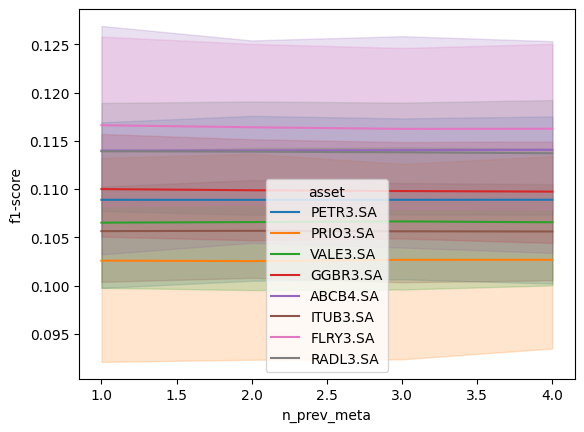

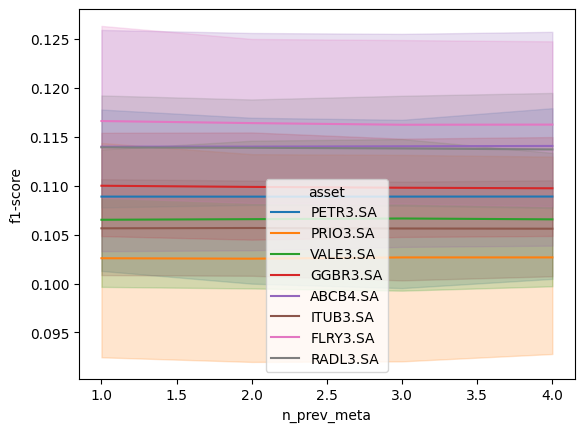

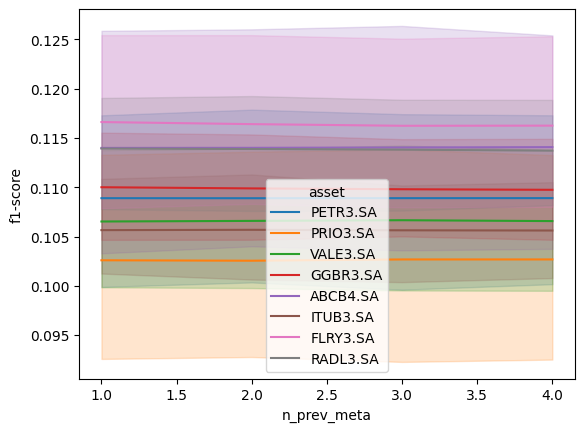

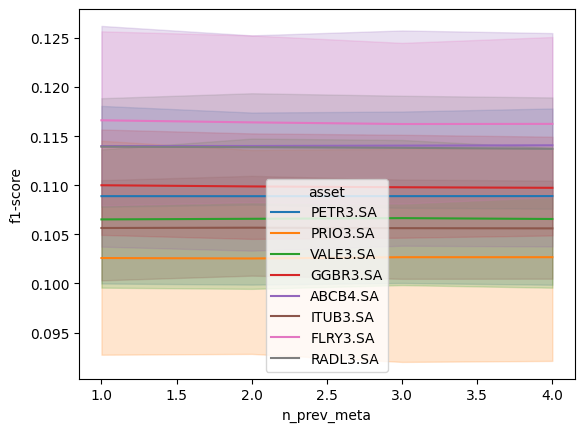

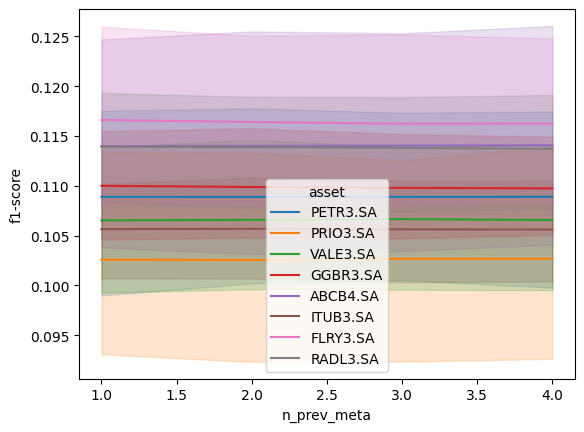

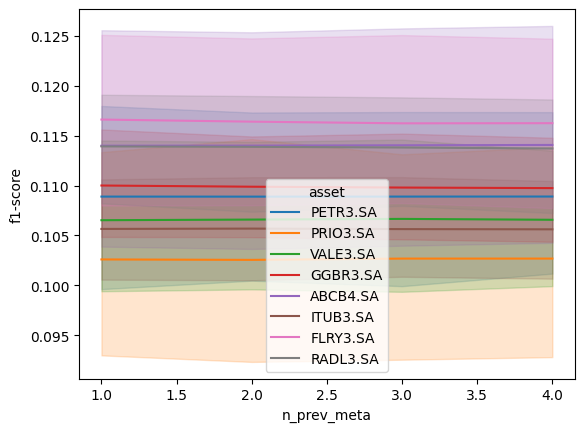

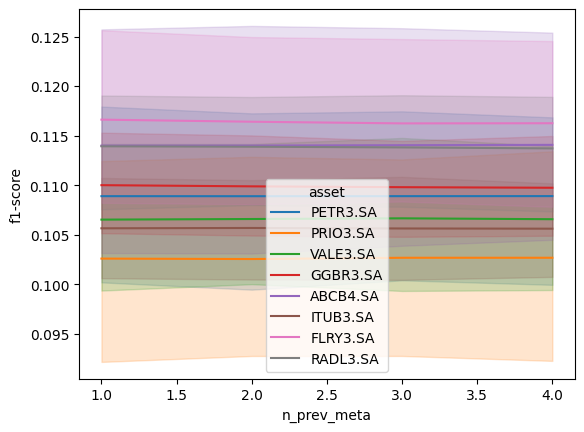

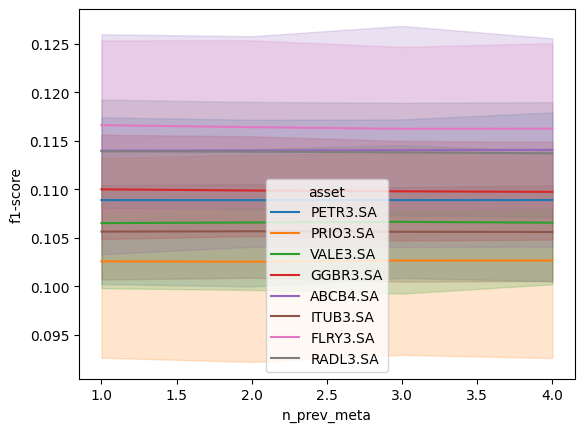

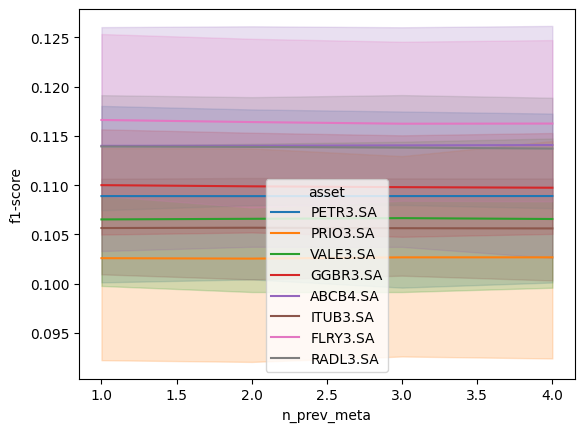

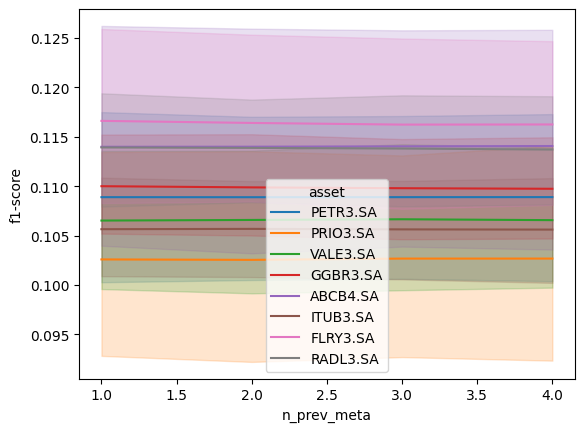

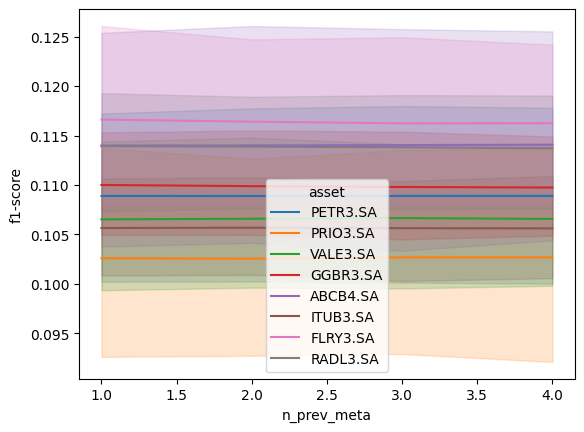

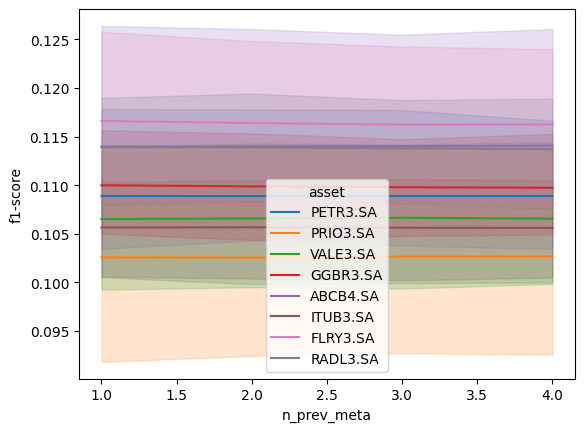

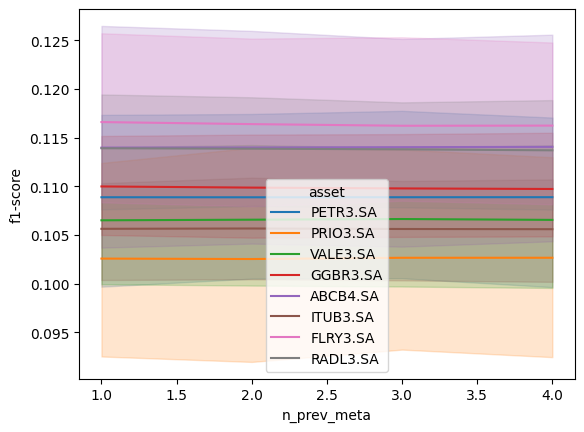

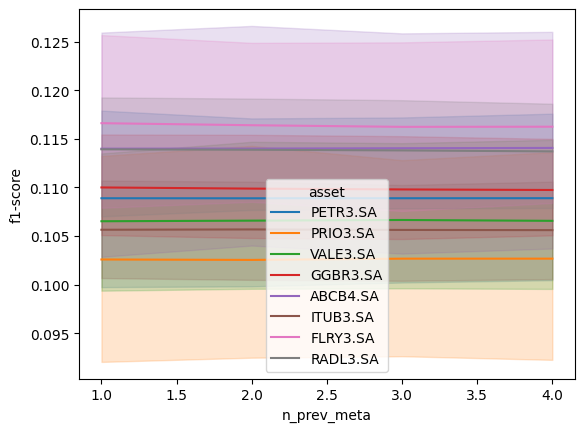

In [8]:
for years_train in df_f1_macro.years_train.unique():
    
    

    sns.lineplot(data=df_f1_macro, x="n_prev_meta", y="f1-score", hue="asset")
    
    plt.show()